# Single-cell Time Series Interpolation

This notebook runs OT-CFM, SB-CFM and SF2M on the embryoid body data, preprocessed according to the notebooks in `preprocessing`. Here we optimize a single network to model cells over time on the 2D PHATE projection. The same process applies for any other representation. In the paper we compare quantitatively on PCA components and highly variable genes.

Note that to run this notebook you well need the `ebdata_v3.h5ad` data object, which is accessible at https://data.mendeley.com/datasets/hhny5ff7yj/1 along with the other single cell datasets used in this work.

Note that to reproduce the results in the paper, the PC dimensions are taken from this data object https://github.com/KrishnaswamyLab/TrajectoryNet/blob/master/data/eb_velocity_v5.npz, which is not quite the same as the PCs here due to different preprocessing. The highly variable genes were selected with the `sc.pp.highly_variable_genes` function with `n_top_genes=XXX`.

To train the model here we build a batch of all timepoint pairs together. This seems to be the most stable if large batches are affordable.

In [1]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import torch
import torchsde
from torchdyn.core import NeuralODE
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models import MLP
from torchcfm.utils import plot_trajectories, torch_wrapper

savedir = "models/single-cell"
os.makedirs(savedir, exist_ok=True)

In [2]:
adata = sc.read_h5ad("../data/ebdata_v2.h5ad")
adata

AnnData object with n_obs × n_vars = 18203 × 17789
    obs: 'sample_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'dpt_pseudotime', '1d-phate'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_name', 'gene_id', 'gene_name_id'
    uns: 'diffmap_evals', 'iroot', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'sample_labels_colors', 'tsne', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_phate', 'X_phate_real_time', 'X_phate_time', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

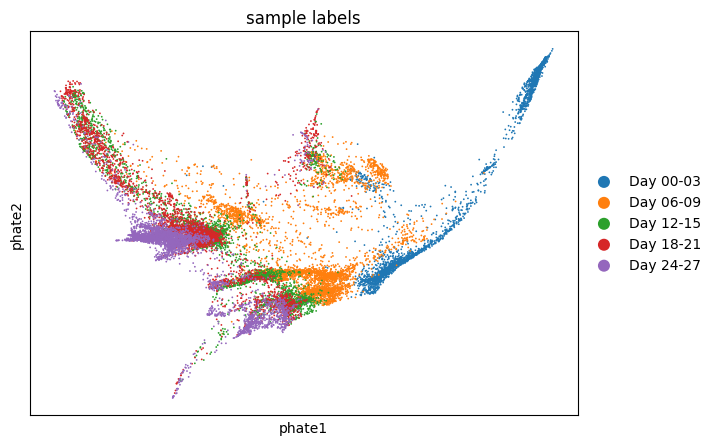

In [3]:
sc.pl.scatter(adata, basis="phate", color="sample_labels")

In [4]:
n_times = len(adata.obs["sample_labels"].unique())
# Standardize coordinates
coords = adata.obsm["X_phate"]
coords = (coords - coords.mean(axis=0)) / coords.std(axis=0)
adata.obsm["X_phate_standardized"] = coords
X = [
    adata.obsm["X_phate_standardized"][adata.obs["sample_labels"].cat.codes == t]
    for t in range(n_times)
]

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
sigma = 0.1
dim = 2
ot_cfm_model = MLP(dim=dim, time_varying=True, w=64).to(device)
ot_cfm_optimizer = torch.optim.Adam(ot_cfm_model.parameters(), 1e-4)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

In [6]:
import scprep


def plot_trajectories(traj, legend=True):
    n = 2000
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    scprep.plot.scatter(
        adata.obsm["X_phate_standardized"][:, 0],
        adata.obsm["X_phate_standardized"][:, 1],
        c=adata.obs["sample_labels"],
        ax=ax,
    )
    # ax.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
    ax.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.4, alpha=0.1, c="olive")
    # ax.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")

    for i in range(15):
        ax.plot(traj[:, i, 0], traj[:, i, 1], alpha=0.9, c="red")
    if legend:
        plt.legend([r"$p_0$", r"$p_t$", r"$p_1$", r"$X_t \mid X_0$"])
    # plt.xticks([])
    # plt.yticks([])
    # plt.axis("off")


def get_batch(FM, X, batch_size, n_times, return_noise=False):
    """Construct a batch with point sfrom each timepoint pair"""
    ts = []
    xts = []
    uts = []
    noises = []
    for t_start in range(n_times - 1):
        x0 = (
            torch.from_numpy(X[t_start][np.random.randint(X[t_start].shape[0], size=batch_size)])
            .float()
            .to(device)
        )
        x1 = (
            torch.from_numpy(
                X[t_start + 1][np.random.randint(X[t_start + 1].shape[0], size=batch_size)]
            )
            .float()
            .to(device)
        )
        if return_noise:
            t, xt, ut, eps = FM.sample_location_and_conditional_flow(
                x0, x1, return_noise=return_noise
            )
            noises.append(eps)
        else:
            t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1, return_noise=return_noise)
        ts.append(t + t_start)
        xts.append(xt)
        uts.append(ut)
    t = torch.cat(ts)
    xt = torch.cat(xts)
    ut = torch.cat(uts)
    if return_noise:
        noises = torch.cat(noises)
        return t, xt, ut, noises
    return t, xt, ut

## OT-CFM

In [7]:
for i in tqdm(range(10000)):
    ot_cfm_optimizer.zero_grad()
    t, xt, ut = get_batch(FM, X, batch_size, n_times)
    vt = ot_cfm_model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    ot_cfm_optimizer.step()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:06<00:00, 27.25it/s]


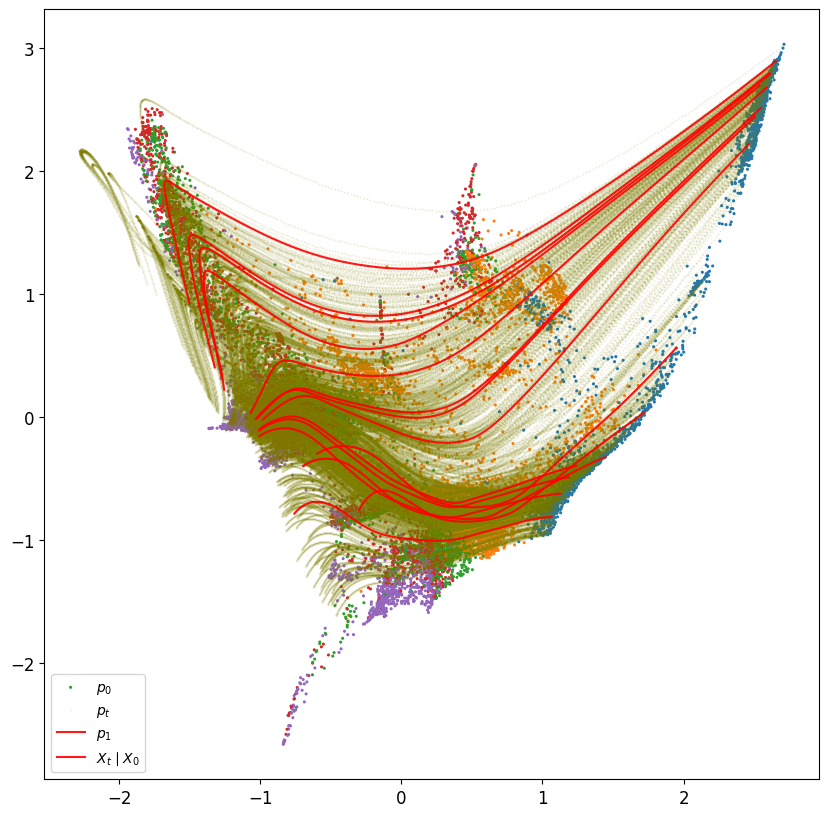

In [8]:
node = NeuralODE(torch_wrapper(ot_cfm_model), solver="dopri5", sensitivity="adjoint")
with torch.no_grad():
    traj = node.trajectory(
        torch.from_numpy(X[0][:1000]).float().to(device),
        t_span=torch.linspace(0, n_times - 1, 400),
    ).cpu()
    plot_trajectories(traj.cpu().numpy())

In [9]:
torch.save(
    {
        "model": ot_cfm_model,
        "optimizer": ot_cfm_optimizer,
    },
    f"{savedir}/ot_cfm_single_cell.pt",
)

## SF2M



In [10]:
sigma = 0.25
sf2m_model = MLP(dim=dim, time_varying=True, w=64).to(device)
sf2m_score_model = MLP(dim=dim, time_varying=True, w=64).to(device)
sf2m_optimizer = torch.optim.AdamW(
    list(sf2m_model.parameters()) + list(sf2m_score_model.parameters()), 1e-4
)
SF2M = SchrodingerBridgeConditionalFlowMatcher(sigma=sigma)

In [11]:
max_norm_ut = torch.tensor(0.0)
for i in tqdm(range(10000)):
    sf2m_optimizer.zero_grad()
    t, xt, ut, eps = get_batch(SF2M, X, batch_size, n_times, return_noise=True)
    lambda_t = SF2M.compute_lambda(t % 1)
    vt = sf2m_model(torch.cat([xt, t[:, None]], dim=-1))
    st = sf2m_score_model(torch.cat([xt, t[:, None]], dim=-1))
    flow_loss = torch.mean((vt - ut) ** 2)
    # max_norm_ut = torch.maximum(torch.max(torch.sum(ut**2, dim=1)), max_norm_ut)
    score_loss = torch.mean((lambda_t[:, None] * st + eps) ** 2)
    if i % 1000 == 0:
        # print(max_norm_ut)
        print(f"{i}: {flow_loss.item():0.2f}, {score_loss.item():0.2f}")
    loss = flow_loss + score_loss

    loss.backward()
    sf2m_optimizer.step()

  0%|                                                                                                                                             | 3/10000 [00:00<08:31, 19.53it/s]

0: 0.87, 1.36


 10%|█████████████▊                                                                                                                            | 1005/10000 [00:38<06:07, 24.46it/s]

1000: 0.46, 0.87


 20%|███████████████████████████▋                                                                                                              | 2004/10000 [01:16<05:38, 23.60it/s]

2000: 0.35, 0.83


 30%|█████████████████████████████████████████▍                                                                                                | 3006/10000 [01:54<04:25, 26.31it/s]

3000: 0.50, 0.85


 40%|███████████████████████████████████████████████████████▎                                                                                  | 4005/10000 [02:33<04:39, 21.46it/s]

4000: 0.28, 0.83


 50%|█████████████████████████████████████████████████████████████████████                                                                     | 5004/10000 [03:11<03:07, 26.60it/s]

5000: 2.36, 0.85


 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                       | 6003/10000 [03:49<02:38, 25.17it/s]

6000: 0.35, 0.82


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7005/10000 [04:27<01:58, 25.34it/s]

7000: 0.33, 0.84


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8004/10000 [05:06<01:23, 23.87it/s]

8000: 0.24, 0.80


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 9003/10000 [05:45<00:39, 24.96it/s]

9000: 0.32, 0.78


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:23<00:00, 26.10it/s]


In [12]:
node = NeuralODE(torch_wrapper(sf2m_model), solver="euler", sensitivity="adjoint")
x0 = torch.from_numpy(X[0][:1000]).float()
with torch.no_grad():
    traj = node.trajectory(
        x0.to(device),
        t_span=torch.linspace(0, n_times - 1, 400, device=device),
    ).cpu()

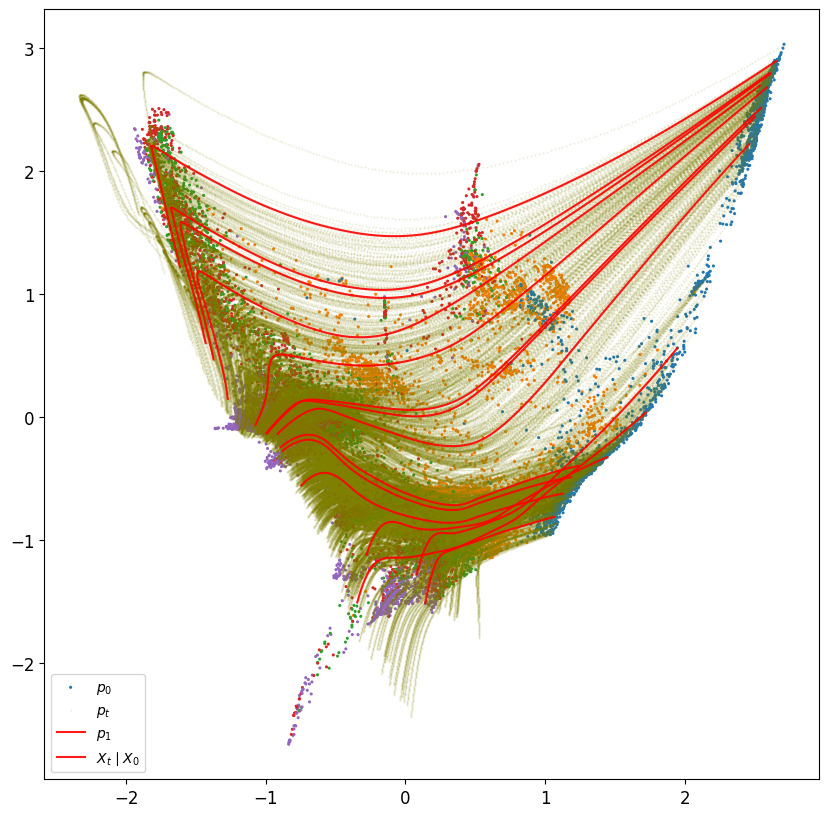

In [13]:
plot_trajectories(traj.cpu().numpy())

In [14]:
class SDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, ode_drift, score, input_size=(3, 32, 32), sigma=1.0):
        super().__init__()
        self.drift = ode_drift
        self.score = score
        self.input_size = input_size
        self.sigma = sigma

    # Drift
    def f(self, t, y):
        y = y.view(-1, *self.input_size)
        if len(t.shape) == len(y.shape):
            x = torch.cat([y, t], 1)
        else:
            x = torch.cat([y, t.repeat(y.shape[0])[:, None]], 1)
        return self.drift(x).flatten(start_dim=1) + self.score(x).flatten(start_dim=1)

    # Diffusion
    def g(self, t, y):
        return torch.ones_like(y) * self.sigma


sde = SDE(sf2m_model, sf2m_score_model, input_size=(2,), sigma=sigma)
with torch.no_grad():
    sde_traj = torchsde.sdeint(
        sde,
        x0.to(device),
        ts=torch.linspace(0, n_times - 1, 400, device=device),
    ).cpu()

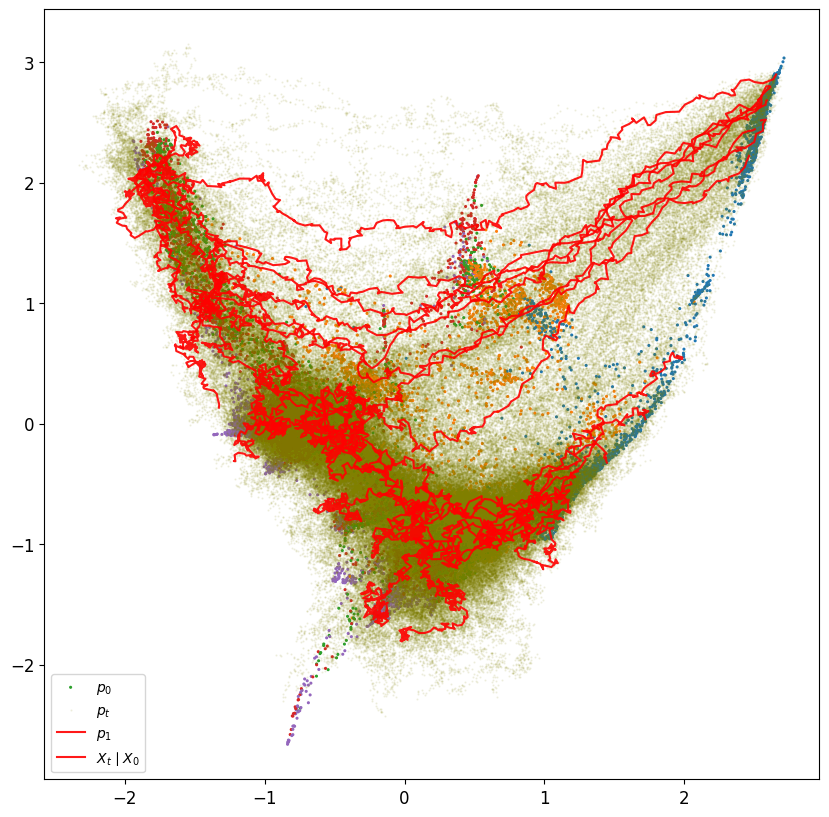

In [15]:
plot_trajectories(sde_traj.detach().cpu().numpy())

In [16]:
torch.save(
    {
        "model": sf2m_model,
        "score_model": sf2m_score_model,
        "optimizer": sf2m_optimizer,
    },
    f"{savedir}/sf2m_single_cell_sigma_{sigma}.pt",
)

# Evolution of trajectories between SF2M's probability flow ODE (SB-CFM) and SF2M

## Starting from a cell at day 0

In [17]:
node = NeuralODE(torch_wrapper(sf2m_model), solver="euler", sensitivity="adjoint")
x0 = torch.from_numpy(X[0][:1000]).float()
with torch.no_grad():
    traj = node.trajectory(
        x0[2].repeat(20).view(20, 2).to(device),
        t_span=torch.linspace(0, n_times - 1, 400, device=device),
    ).cpu()
# plot_trajectories(traj.cpu().numpy())

In [18]:
with torch.no_grad():
    sde_traj = torchsde.sdeint(
        sde,
        x0[2].repeat(20).view(20, 2).to(device),
        ts=torch.linspace(0, n_times - 1, 400, device=device),
    ).cpu()

In [19]:
traj = traj.detach().cpu().numpy()
sde_traj = sde_traj.detach().cpu().numpy()

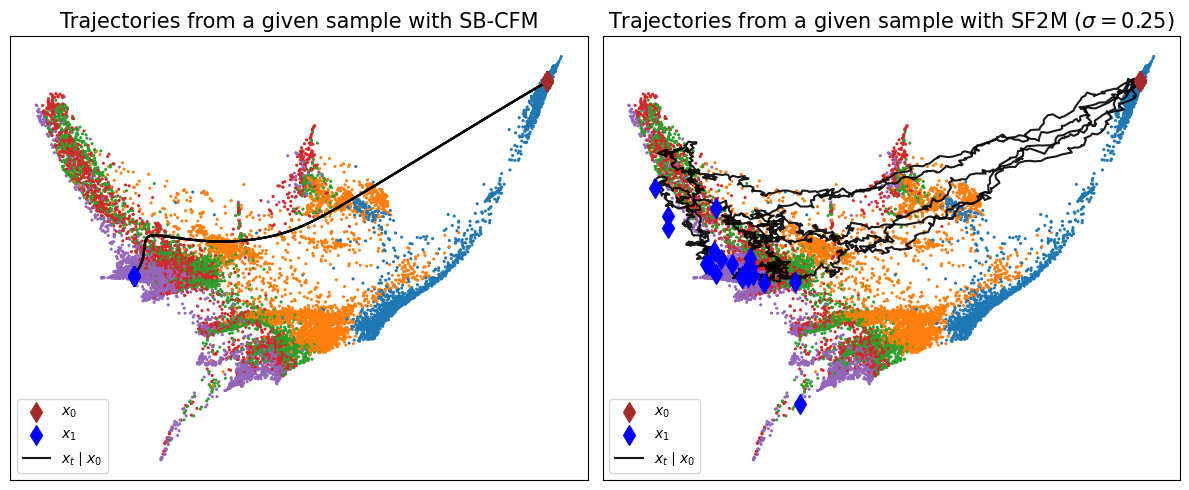

In [20]:
n = 2000
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(traj[0, :n, 0], traj[0, :n, 1], s=100, alpha=1, marker="d", c="brown", zorder=3)
ax1.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=100, alpha=1, marker="d", c="blue", zorder=3)

for i in range(5):
    ax1.plot(traj[:, i, 0], traj[:, i, 1], alpha=0.9, c="black", zorder=2)

scprep.plot.scatter(
    adata.obsm["X_phate_standardized"][:, 0],
    adata.obsm["X_phate_standardized"][:, 1],
    c=adata.obs["sample_labels"],
    ax=ax1,
    legend=None,
)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Trajectories from a given sample with SB-CFM", fontsize=15)
ax1.legend([r"$x_0$", r"$x_1$", r"$x_t \mid x_0$"])


ax2.scatter(
    sde_traj[0, :n, 0], sde_traj[0, :n, 1], s=100, alpha=1, marker="d", c="brown", zorder=3
)
ax2.scatter(
    sde_traj[-1, :n, 0], sde_traj[-1, :n, 1], s=100, alpha=1, marker="d", c="blue", zorder=3
)

for i in range(5):
    ax2.plot(sde_traj[:, i, 0], sde_traj[:, i, 1], alpha=0.9, c="black", zorder=2)

scprep.plot.scatter(
    adata.obsm["X_phate_standardized"][:, 0],
    adata.obsm["X_phate_standardized"][:, 1],
    c=adata.obs["sample_labels"],
    ax=ax2,
    legend=None,
)

ax2.legend([r"$x_0$", r"$x_1$", r"$x_t \mid x_0$"])

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title(
    r"Trajectories from a given sample with SF2M $(\sigma={})$".format(sigma), fontsize=15
)

plt.tight_layout()
plt.savefig("conditonal_trajectory_sf2m_sigma_{}.png".format(sigma))

## Starting from a cell at an older time (day 25)

In [21]:
len(X)

5

In [22]:
node = NeuralODE(torch_wrapper(sf2m_model), solver="euler", sensitivity="adjoint")
x0 = torch.from_numpy(X[1][:1000]).float()
with torch.no_grad():
    traj = node.trajectory(
        x0[1].repeat(15).view(15, 2).to(device),
        t_span=torch.linspace(1, n_times - 1, 300, device=device),
    ).cpu()

with torch.no_grad():
    sde_traj = torchsde.sdeint(
        sde,
        x0[1].repeat(15).view(15, 2).to(device),
        ts=torch.linspace(1, n_times - 1, 300, device=device),
    ).cpu()

traj = traj.detach().cpu().numpy()

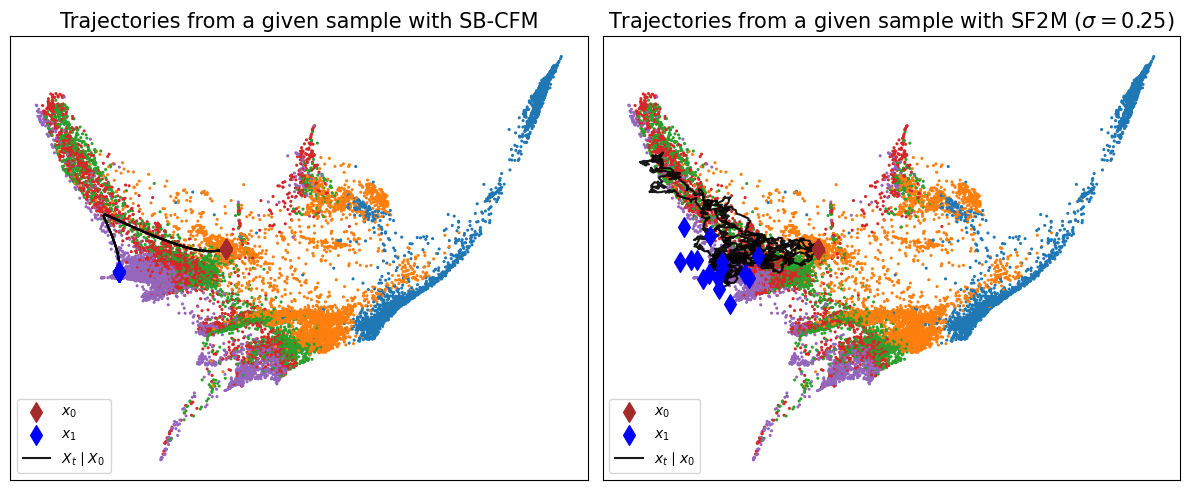

In [23]:
n = 2000
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


ax1.scatter(traj[0, :n, 0], traj[0, :n, 1], s=100, alpha=1, marker="d", c="brown", zorder=3)
ax1.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=100, alpha=1, marker="d", c="blue", zorder=3)

for i in range(5):
    ax1.plot(traj[:, i, 0], traj[:, i, 1], alpha=0.9, c="black", zorder=2)

scprep.plot.scatter(
    adata.obsm["X_phate_standardized"][:, 0],
    adata.obsm["X_phate_standardized"][:, 1],
    c=adata.obs["sample_labels"],
    ax=ax1,
    legend=None,
)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Trajectories from a given sample with SB-CFM", fontsize=15)
ax1.legend([r"$x_0$", r"$x_1$", r"$X_t \mid X_0$"])


ax2.scatter(
    sde_traj[0, :n, 0], sde_traj[0, :n, 1], s=100, alpha=1, marker="d", c="brown", zorder=3
)
ax2.scatter(
    sde_traj[-1, :n, 0], sde_traj[-1, :n, 1], s=100, alpha=1, marker="d", c="blue", zorder=3
)

for i in range(5):
    ax2.plot(sde_traj[:, i, 0], sde_traj[:, i, 1], alpha=0.9, c="black", zorder=2)


scprep.plot.scatter(
    adata.obsm["X_phate_standardized"][:, 0],
    adata.obsm["X_phate_standardized"][:, 1],
    c=adata.obs["sample_labels"],
    ax=ax2,
    legend=None,
)

ax2.legend([r"$x_0$", r"$x_1$", r"$x_t \mid x_0$"])

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title(
    r"Trajectories from a given sample with SF2M $(\sigma={})$".format(sigma), fontsize=15
)
# plt.axis("off")

plt.tight_layout()
plt.savefig("conditonal_trajectory_sf2m_sigma_{}_from_later_time.png".format(sigma))

### As SB-CFM is a deterministic process, it only ends up at one final location contrary to our model SF2M that models a stochastic process and produces different outputs.